# RO-MPI validation

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import warnings
import tqdm
import pathlib
import cmocean
import os

# Import custom modules
import src.utils
from src.XRO import XRO, xcorr

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def fit_RO_to_ensemble(model, T_var, h_var, fit_to_members=False, ac_mask_idx=None):
    """Fit RO parameters to ensemble"""

    ## fit model and generate synthetic ensemble
    if fit_to_members:

        ## fit to individual ensemble members
        kwargs = dict(model=model, T_var=T_var, h_var=h_var, verbose=True)
        _, params = src.utils.get_RO_ensemble(Th_early, **kwargs)

    else:

        ## fit to all ensemble members simultaneously
        params = model.fit_matrix(Th_early[[T_var, h_var]], ac_mask_idx=ac_mask_idx)

    return params


def generate_RO_ensemble(model, params, fit_to_members=False, **simulation_kwargs):
    """generate RO ensemble using given model and parameters"""

    if fit_to_members:

        RO_ensemble = src.utils.generate_ensemble(model, params, **simulation_kwargs)

    else:

        RO_ensemble = model.simulate(fit_ds=RO_params_early, **simulation_kwargs)

    return RO_ensemble


def plot_xcorr(ax, data, color, label=None):
    """plot mean and bounds for data"""

    ## center
    ax.plot(
        data.lag,
        data.sel(posn="center"),
        c=color,
        label=label,
    )

    ## bounds
    ax.fill_between(
        data.lag, data.sel(posn="upper"), data.sel(posn="lower"), color=color, alpha=0.2
    )

    return

## Load data

In [3]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

## Fit RO to ensemble data

In [4]:
## specify variables to use in RO fit order of annual cycle
T_var = "T_3"
h_var = "h_w"
ac_order = 3

## specify whether to fit parameters to each ens. member individually
## if False, fit single set of parameters to all ensemble members
fit_to_members = False

## specify which indices to mask annual cycle out for. One of None or [(y_idx0, x_idx0), ...]
ac_mask_idx = [(1, 1)]
# ac_mask_idx = None

## get data for early/late period
Th_early = Th.isel(time=slice(None, 588))
Th_late = Th.isel(time=slice(-588, None))

## specify model to use
model = XRO(ncycle=12, ac_order=ac_order, is_forward=True)

## fit the model
RO_params_early = fit_RO_to_ensemble(
    model,
    T_var=T_var,
    h_var=h_var,
    fit_to_members=False,
    ac_mask_idx=ac_mask_idx,
)

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


## Get ensemble of RO simulations

In [5]:
## specify arguments for simulation
simulation_kwargs = dict(
    nyear=49, ncopy=1000, seed=1000, X0_ds=Th[[T_var, h_var]].isel(member=0, time=0)
)

## perform simulation
RO_ensemble = generate_RO_ensemble(
    model, RO_params_early, fit_to_members=fit_to_members, **simulation_kwargs
)

## Diagnostics

### Seasonality

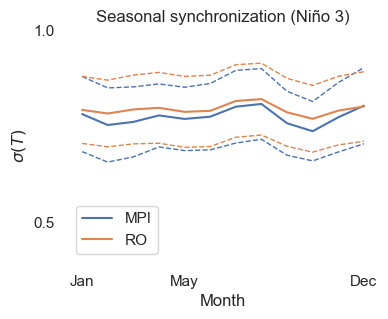

In [6]:
## func to compute std dev as a function of month
get_std = lambda x: x.groupby("time.month").std("time")

## wrapper function to get mean and ± 1 std
get_stats = lambda x: src.utils.get_ensemble_stats(get_std(x[T_var]))

## compute std for each dataset
mpi_std_plot = get_stats(Th_early)
ro_std_plot = get_stats(RO_ensemble)

## months (x-coordinate for plotting
months = np.arange(1, 13)

### Set up plot
fig, ax = plt.subplots(figsize=(4, 3))

## plot MPI ensemble mean
mpi_plot = ax.plot(months, mpi_std_plot.sel(posn="center"), label="MPI")

## plot MPI bounds
kwargs = dict(c=mpi_plot[0].get_color(), ls="--", lw=1)
for bound in ["upper", "lower"]:
    ax.plot(months, mpi_std_plot.sel(posn=bound), **kwargs)

## plot RO ensemble mean
ro_plot = ax.plot(months, ro_std_plot.sel(posn="center"), label="RO")

## plot RO bounds
kwargs = dict(c=ro_plot[0].get_color(), ls="--", lw=1)
for bound in ["upper", "lower"]:
    ax.plot(months, ro_std_plot.sel(posn=bound), **kwargs)

## adjust limits and label
ax.set_ylim([0.4, None])
ax.set_yticks([0.5, 1])
ax.set_xticks([1, 5, 12], labels=["Jan", "May", "Dec"])
ax.set_xlabel("Month")
ax.set_ylabel(f"$\\sigma(T)$")
ax.set_title("Seasonal synchronization (Niño 3)")
ax.legend()
plt.show()

### Power spectrum
To-do...

### $T$, $h$ cross-correlation

Compute cross-correlation

In [29]:
## compute cross-correlation
xcorr_mpi = xcorr(Th_early, Th_early[T_var], maxlags=18)
xcorr_ro = xcorr(RO_ensemble, RO_ensemble[T_var], maxlags=18)

## compute stats
xcorr_mpi_stats = src.utils.get_ensemble_stats(xcorr_mpi)
xcorr_ro_stats = src.utils.get_ensemble_stats(xcorr_ro)

Make plots

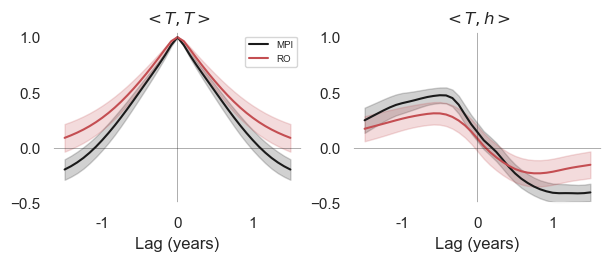

In [30]:
## specify plot properties for legend
legend_prop = dict(size=7)

fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), layout="constrained")

## plot <T,T>
axs[0].set_title(r"$<T, T>$")
plot_xcorr(axs[0], xcorr_mpi_stats[T_var], color="k", label="MPI")
plot_xcorr(axs[0], xcorr_ro_stats[T_var], color="r", label="RO")
axs[0].legend(prop=dict(size=7))


## plot <T,h>
axs[1].set_title(r"$<T, h>$")
plot_xcorr(axs[1], xcorr_mpi_stats[h_var], color="k", label="MPI")
plot_xcorr(axs[1], xcorr_ro_stats[h_var], color="r", label="RO")

## clean up axes and label
for ax in axs:
    ax.set_ylim([-0.5, 1.05])
    ax.set_xticks([-12, 0, 12], labels=[-1, 0, 1])
    ax.set_xlabel("Lag (years)")
    axis_kwargs = dict(c="k", lw=0.5, alpha=0.5)
    ax.axhline(0, **axis_kwargs)
    ax.axvline(0, **axis_kwargs)

plt.show()